# Multi-Head Latent Attention

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class RopelessMLA(nn.Module):
  def __init__(self,d_model,n_heads,kv_latent_dim):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.dh = d_model // n_heads # dimension per head

    # Projection layers
    self.W_q = nn.Linear(d_model,d_model,bias=False)                  # Query projection
    self.W_dkv = nn.Linear(d_model,kv_latent_dim,bias=False)  # Compress into latent KV space
    self.W_uk = nn.Linear(kv_latent_dim,d_model,bias=False)   # Decompress K
    self.W_uv = nn.Linear(kv_latent_dim,d_model,bias=False)   # Decompress V
    self.W_o  = nn.Linear(d_model,d_model,bias=False)

    self.ln = nn.LayerNorm(kv_latent_dim)
    self.register_buffer('absorbed_k',None) # Holds W_q @ W_uk




  def forward(self,x,kv_cache=None,past_length=0):
    B,S,D = x.size()

    # Compute absorbed_k once: W_q @ W_uk, shape: (D, latent_dim)

    if self.absorbed_k is None:
      absorbed = torch.matmul(self.W_q.weight,self.W_uk.weight) # (D,latent_dim)
      self.absorbed_k = absorbed.view(self.n_heads,self.dh,-1) # (n_heads,dh,latent_dim)


    # compress x into latent KV space
    new_c_kv = self.ln(self.W_dkv(x)) # (B,S,latent_dim)
    if kv_cache is None:
      c_kv = new_c_kv
    else:
        c_kv = torch.cat([kv_cache,new_c_kv],dim=1) # (B,S_total,latent_dim )
    S_full = c_kv.size(1)


    # Decompress V to full d_model and split into heads
    v_full = self.W_uv(c_kv) # (B,S_full,D)
    v = v_full.view(B,S_full,self.n_heads,self.dh).transpose(1,2) #(B,n_heads, S_full,)

    # Use input x directly (since W_q is abosorbed)
    q = x.view(B,S,self.n_heads,self.dh) # (B,S,n_heads,dh)

    # Compute attention scores
    attn_scores = torch.zeros(B,self.n_heads,S,S_full,device=x.device)
    for h in range(self.n_heads):
      tmp = torch.matmul(q[:,:,h],self.absorbed_k[h]) #(B,S,latent_dim)
      attn_scores[:,h] = torch.bmm(tmp,c_kv.transpose(1,2)) # (B,S,S_full)


    # Scale and apply causal mask
    attn_scores = attn_scores / (self.dh ** 0.5)
    mask = torch.tril(torch.ones((S,S_full),device=x.device),diagonal=past_length)
    attn_scores = attn_scores.masked_fill(mask.view(1,1,S,S_full) == 0, float('-inf'))

    # Softmax to get attention weights
    attn_weights = F.softmax(attn_scores,dim=-1) #(B,n_heads,S,S_full)

    # Apply attention weights to each head's V seperately

    out_heads = []
    for h in range(self.n_heads):
      context_h = torch.matmul(attn_weights[:,h],v[:,h]) # (B,S,dh)
      out_heads.append(context_h)


    # Concatenate all heads outputs along the feature dimension
    out = torch.cat(out_heads,dim=-1) # (B,S,D)

    return self.W_o(out), c_kv # Final output projection + updated latent cache








# Testing of Memory


In [ ]:
def demo():
  model = RopelessMLA(d_model=512,n_heads=8,kv_latent_dim=256)
  x = torch.randn(1,5,512) # Batch=2,Sequence=10, d_model=512

  out, cache = model(x)
  print(f"Output: {out.shape}, Cache:{cache.shape}")

  # Memory comparison

  std_size = 2 * 2 * 10 * 512 * 4 / 1024 # KB (standard KV: B * 2 (K,V) * T * D * float32 )
  latent_size = 1*2 * 10 * 256 * 4 / 1024  #KB (latent cache: B * T * latent_dim * float32 )
  print(f"Memory: Standard = {std_size:.1f}KB, Latent = {latent_size:.1f}KB, Reduction={std_size/latent_size:.1f}x")


if __name__ == "__main__":
    demo()

Output: torch.Size([1, 5, 512]), Cache:torch.Size([1, 5, 256])
Memory: Standard = 80.0KB, Latent = 20.0KB, Reduction=4.0x


# Cache Testing : Single New Inference

In [ ]:
def demo_cache_usuage():
  torch.manual_seed(0)

  model = RopelessMLA(d_model=8,n_heads=2,kv_latent_dim=4)

  # Step1: Inital Input (sequence of 5 tokens)
  x1 = torch.randn(1,5,8) # (B=1, S=1,D=8)
  out1,cache1 = model(x1)
  print('Step 1: Inital input')
  print(f'Output shape:{out1.shape}')
  print(f"Cache shape{cache1.shape}") # Expect: (1,5,4)

  # Step2: Append 1 token
  x2 = torch.randn(1,1,8) # (B=1,S=1,D=8)
  out2,cache2 = model(x2,kv_cache=cache1,past_length=5)

  print("\nStep 2: New token")
  print(f"Output Shape:{out2.shape}")
  print(f"Cache shape:{cache2.shape}") # Expect: (1,6,4)


demo_cache_usuage()


Step 1: Inital input
Output shape:torch.Size([1, 5, 8])
Cache shapetorch.Size([1, 5, 4])

Step 2: New token
Output Shape:torch.Size([1, 1, 8])
Cache shape:torch.Size([1, 6, 4])


# Cache Testing : Multiple New Inference

In [ ]:
def demo_kv_cache_growth(num_initial_tokens=5,num_new_tokens=3):
  torch.manual_seed(0)

  model = RopelessMLA(d_model=8,n_heads=2,kv_latent_dim=4)

  # Step 1: Start with inital token batch
  x = torch.randn(1,num_initial_tokens,8)
  out,cache = model(x)
  print(f"Step 0: Inital input of {num_initial_tokens} tokens -> cache shape:{cache.shape}")

  # Step 2: Incrementally append new tokens one at a time
  for step in range(1,num_new_tokens + 1):
    new_token = torch.randn(1,1,8) # (B=1,S=1,D=8)
    out,cache = model(new_token, kv_cache=cache,past_length=cache.shape[1])
    print(f"Step {step}: Added 1 token -> cache shape: {cache.shape}")


demo_kv_cache_growth(num_initial_tokens=50,num_new_tokens=4)



Step 0: Inital input of 50 tokens -> cache shape:torch.Size([1, 50, 4])
Step 1: Added 1 token -> cache shape: torch.Size([1, 51, 4])
Step 2: Added 1 token -> cache shape: torch.Size([1, 52, 4])
Step 3: Added 1 token -> cache shape: torch.Size([1, 53, 4])
Step 4: Added 1 token -> cache shape: torch.Size([1, 54, 4])


# Visualizing Wq, Wuk and Wuv matrices for differnt heads

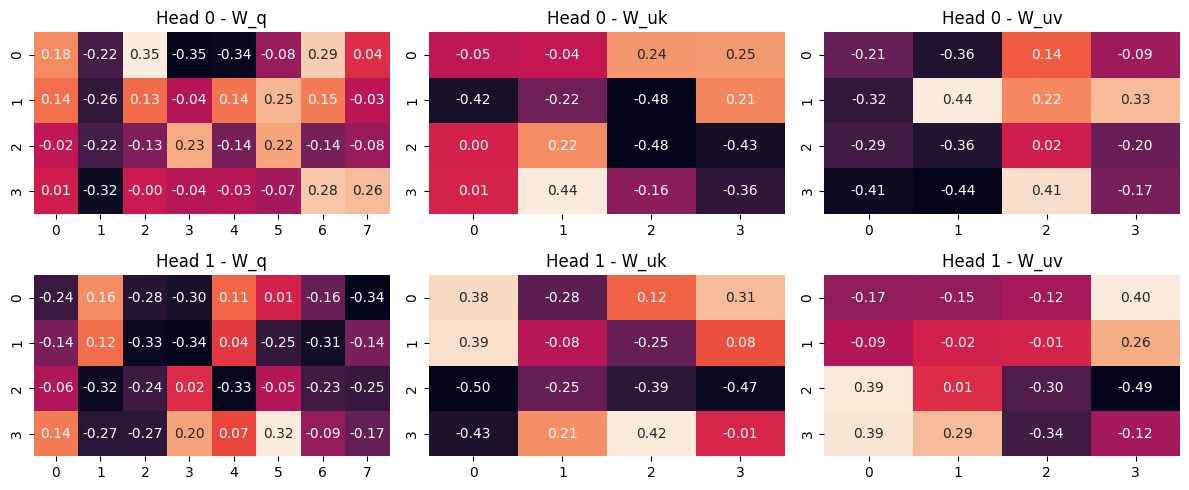

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

class RopelessMLA(nn.Module):
  def __init__(self,d_model=8,n_heads=2,kv_latent_dim=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.dh = d_model // n_heads


    self.W_q = nn.Linear(d_model,d_model,bias=False)
    self.W_uk = nn.Linear(kv_latent_dim,d_model,bias=False)
    self.W_uv = nn.Linear(kv_latent_dim,d_model,bias=False)

model = RopelessMLA()
# Extract weights
W_q = model.W_q.weight.detach().numpy()
W_uk = model.W_uk.weight.detach().numpy()
W_uv = model.W_uv.weight.detach().numpy()


# Split per head
n_heads = model.n_heads
dh = model.dh

W_q_heads = W_q.reshape(n_heads,dh,-1)
W_uk_heads = W_uk.T.reshape(n_heads,dh,-1)
W_uv_heads = W_uv.T.reshape(n_heads,dh,-1)

# Plot heatmaps

fig, axes = plt.subplots(n_heads,3,figsize=(12,5))
for h in range(n_heads):
  sns.heatmap(W_q_heads[h],ax=axes[h,0],cbar=False,annot=True,fmt=".2f")
  axes[h,0].set_title(f"Head {h} - W_q")


  sns.heatmap(W_uk_heads[h],ax=axes[h,1],cbar=False,annot=True,fmt=".2f")
  axes[h,1].set_title(f"Head {h} - W_uk")

  sns.heatmap(W_uv_heads[h],ax=axes[h,2],cbar=False,annot=True,fmt=".2f")
  axes[h,2].set_title(f"Head {h} - W_uv")


plt.tight_layout()
plt.show()
